# Plotting collider Dark Matter constraints on Direct Detection planes: an example notebook

Making up 85% of the matter in the universe, **dark matter** (DM) is sought by multiple experiments, following different theoretical hypotheses. Making progress on our understanding of the nature of dark matter requires a strategy that includes a variety of complementary experiments. In this notebook, we show how (future) collider constraints are displayed in the DM-nucleon cross-section plane that is used by direct detection experiments, using a benchmark model where the interactions between dark matter and known (Standard Model, or SM) particles are mediated by a new vector particle.  

**Credits**: This work is conducted in the context of the 2025 European Strategy Update, and is one of the projects in the initiative for Dark Matter in Europe and Beyond (https://iDMEu.org). The explanatory text in these cells is taken from [2] and [3]. This project has received funding from the European Research Council under the European Union’s Horizon 2020 research and innovation program (grant agreement 679305 and 101002463). The main authors of this notebook are Katherine Pachal (TRIUMF), Léo Chazallet (LAPP) and Caterina Doglioni (University of Manchester). 

## Introduction to the model and its parameters

The Feynman diagram of the model we are testing for collider experiments is below. The mediator is termed as $V$ ($A-V$ represents the axial vector mediator), quarks are denoted by $q$ and gluons by $g$, while the Dark Matter particle is called $\chi$.

The relevant parameters for this model are:
   * The coupling between quarks and the mediator $g_q$
   * The coupling between DM and the mediator $g_{DM}$
   * The mediator mass $m_V$
   * The dark matter mass $m_{DM}$

The model also allows for a single universal coupling strength $g_l$ for all mediator-lepton interactions, including neutrinos (this is not depicted in the diagrams below). No mixing with the Z-boson is included in this model.

While this is a _simplified model_, meaning that not all of its features are fully developed at all scales, portraying the sensitivities of different experiments using a common benchmark is still useful to understand how DM would manifest across experiments in similar classes of models. 

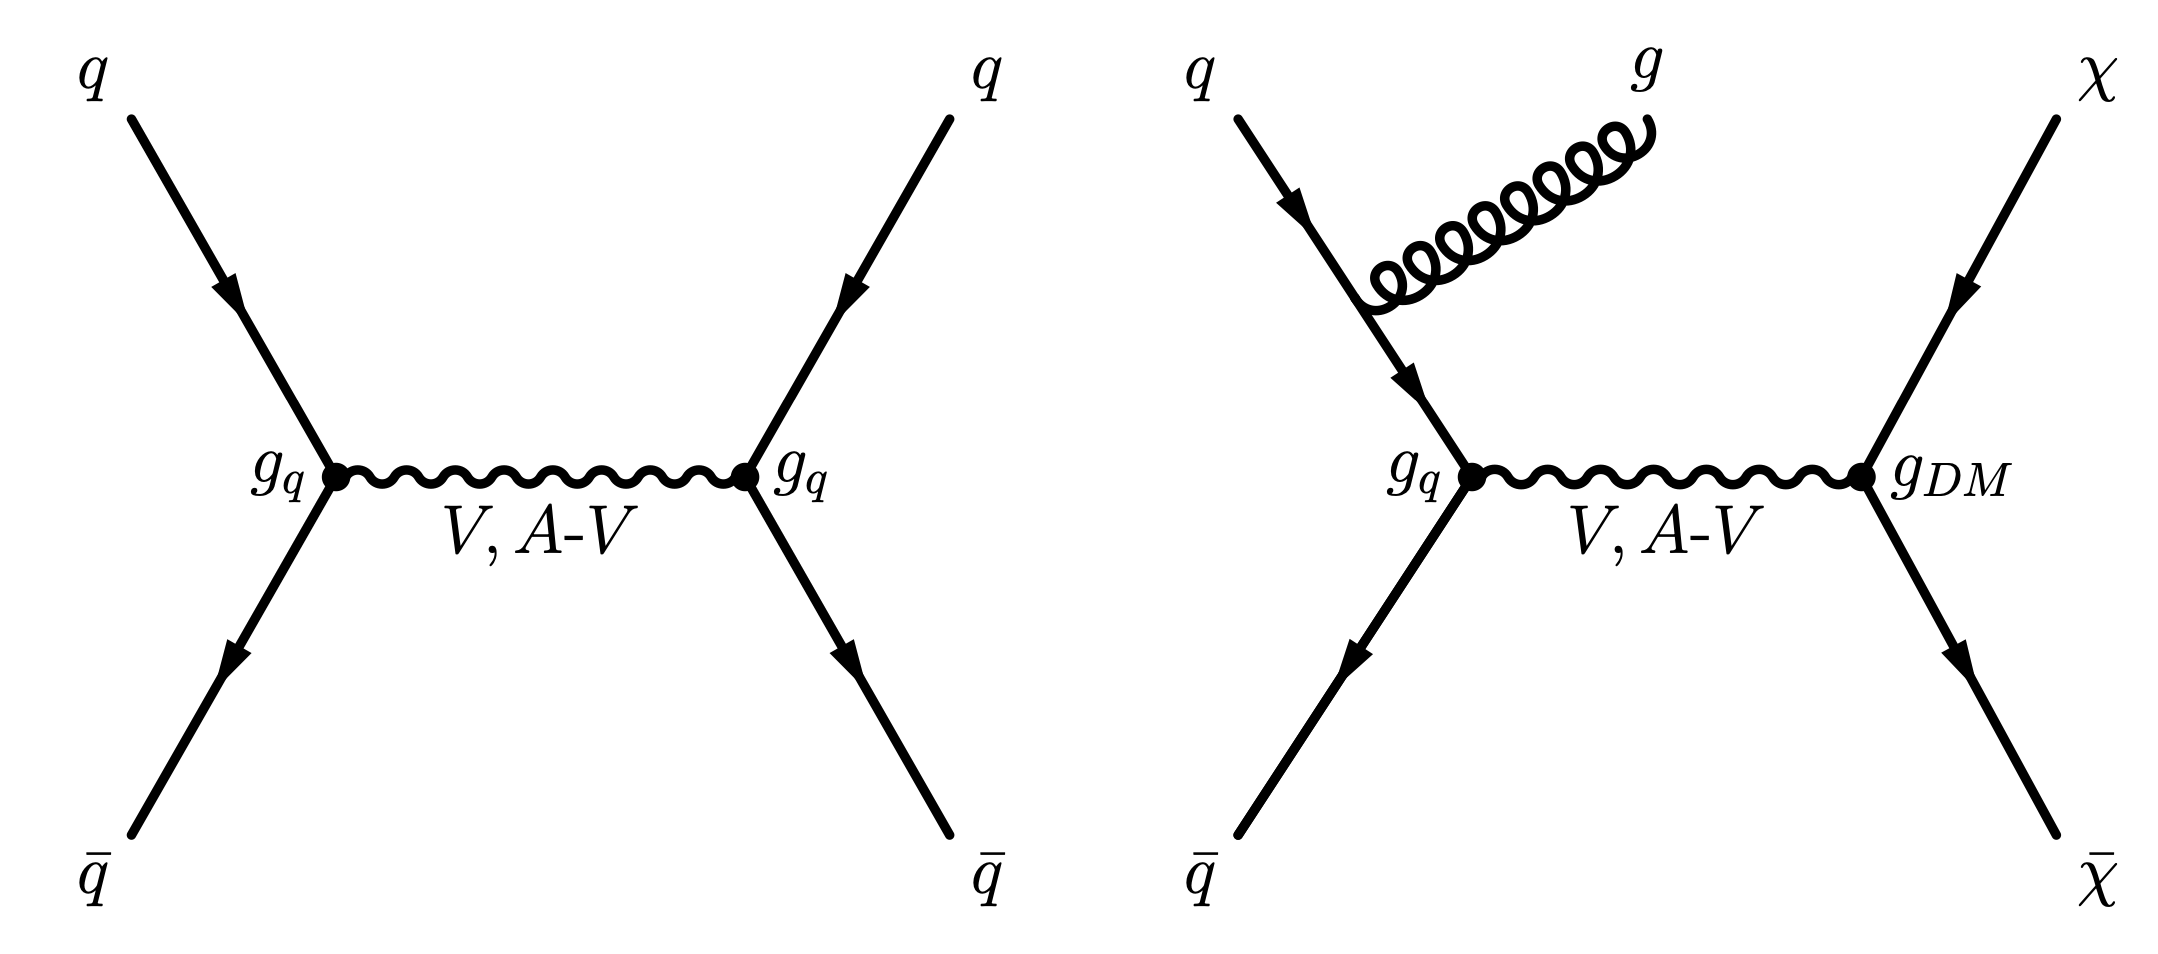

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "img/Feynman.png", width=600, height=300)

## Searches at colliders

Due to the presence of both SM and DM couplings, the main search avenues for this kind of models at colliders are (a, left-hand side diagram) by looking for localized (resonant) excesses signaling the presence of a mediator decaying into pairs of DM particles and (b, right-hand side diagram) by looking for an excess of missing energy (MET) from the mediator decaying to DM particles.  

The inputs received from the collider community in the context of Snowmass 2021 and used to prepare the plots in this notebook are: 
   * MET+jet search (also called monojet search) using the ATLAS detector at the upgraded LHC (HL-LHC) [hllhc-monojet];
   * MET+jet and MET+hadronically decaying vector boson at the Future Hadron Collider in the Future Circular Collider (FCC) complex [Harris:2015kda];
   * Dijet resonance search at the HL-LHC and at the Future Hadron Collider [Harris:2022kls];
   * Dilepton resonance search at the HL-LHC using the ATLAS detector [ATL-PHYS-PUB-2018-044]. The CMS version of this search is also available at [CMS-PAS-FTR-21-005].

## Motivation

[Explain that we need more than one experiment to make a discovery] 

So far, the presentation of LHC and future hadron collider results has focused on four benchmark scenarios with specific coupling values within these simplified models - in particular, one of the chosen benchmarks (also used in the 2019 European Strategy Briefing Book [4]) use g_q = 0.25, g_l = 0 and g_DM = 1.0. [The following is a WIP] In this work, we highlight the extensions of this benchmark scenario to arbitrary couplings and show how the areas of complementarity (where both direct detection and collider experiments could share information about a discovery) change under different coupling scenarios. 

## Notebook for overlaying the sensitivity of future collider and direct detection experiments 

### Common imports and functions

Assorted imports, including a helper script to collect and display direct detection curves

In [109]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from helpers import pairwise
from shapely.geometry import Polygon as shapely_pol
import pickle
#from basic_plotter import *
import ROOT
import itertools as it
import sys, os
sys.path.insert(1, '../inputs/directdetection')
import collect_dd

FULL_SPECTRA_PATH = "data/Full_spectra"  # arXiv:[2109.03116]
OUTPUT_FOLDER = "plots"

import warnings
warnings.filterwarnings('ignore')

Some more helper functions (TODO: move outside this notebook at some point...)

In [114]:
def interpolate_vertical(x1,y1,x2,y2,n) :
    ov = sorted([[y1,x1],[y2,x2]])
    new_ys = np.linspace(ov[0][0], ov[1][0], num=n)
    new_xs = np.interp(new_ys,[ov[0][0],ov[1][0]],[ov[0][1],ov[1][1]])
    vertices = list(zip(new_xs,new_ys))
    return vertices if y1 < y2 else list(reversed(vertices))

In [113]:
def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = it.tee(iterable)
    next(b, None)
    return zip(a, b)

In [5]:
# Collect direct detection contours for comparison plots.
def get_dd_lines(lineinfo) :
    legend_lines = list(lineinfo.keys())
    dd_lines = []
    for name in legend_lines :
        dd_lines.append(lineinfo[name])
    return legend_lines, dd_lines

### Plotting collider curves - WIP

In [130]:
from matplotlib.colors import ColorConverter#,ListedColormap, LinearSegmentedColormap,rgb2hex
import matplotlib.colors as cols
from matplotlib.patches import Polygon
from shapely.ops import unary_union, polygonize

In [131]:
sd_proton = collect_dd.get_sd_proton()
sd_neutron = collect_dd.get_sd_neutron()
spin_independent = collect_dd.get_spin_independent()

In [132]:
test_gq = [0.25]
test_gdm = [1.0]
test_gl = [0.00]

In [133]:
def get_aspect_ratio(ax, isloglog=False, islinearlog=False) :
  ratio = 1.0
  xleft, xright = ax.get_xlim()
  ybottom, ytop = ax.get_ylim()
  if isloglog :
    nUnitsX = np.log10(xright) - np.log10(xleft)
    nUnitsY = np.log10(ytop) - np.log10(ybottom)
    return nUnitsX/nUnitsY
  elif islinearlog :
    nUnitsY = np.log10(ytop) - np.log10(ybottom)
    nUnitsX = (xright-xleft)
    return abs(nUnitsX/nUnitsY)
  else :
    return abs((xright-xleft)/(ybottom-ytop))*ratio

In [134]:
# eqn 4.10 https://arxiv.org/pdf/1603.04156.pdf#page12
def calculate_sd(gq, gdm, gl, mMed, mdm) :

    mn = 0.939 # GeV
    val = 2.4e-42 * (gq*gdm/0.25)**2 * (1000./mMed)**4 * (mn*mdm/(mn+mdm))**2
    return val

# eqn 4.3: https://arxiv.org/pdf/1603.04156.pdf#page12
def calculate_si(gq, gdm, gl, mMed, mdm) :

    mn = 0.939 # GeV
    val = 6.9e-41 * (gq*gdm/0.25)**2 * (1000./mMed)**4 * (mn*mdm/(mn+mdm))**2
    return val

In [135]:
def merge_exclusions(contour_list) :

    # If there's only one, do nothing.
    if len(contour_list) == 1 :
      return contour_list[0]
    elif len(contour_list) == 0 :
      return None

    # No longer matters which input each contour is from:
    # flatten the input to a simple list of polygons
    contour_list = [item for sublist in contour_list for item in sublist]

    # Merge
    merged = unary_union(contour_list)

    # Split multipolygon back into list of polygons, if needed
    poly_list = []
    if merged.geom_type == 'MultiPolygon':
      poly_list = [poly for poly in merged.geoms]
    else :
      poly_list = [merged]

    return poly_list

In [136]:
def colorFader_collider_only(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(ColorConverter.to_rgb(c1))
    c2=np.array(ColorConverter.to_rgb(c2))
    return cols.to_hex((1-mix)*c1 + mix*c2)

In [137]:
def coreDrawFunction_collider_only(axes,contour_groups,legend_lines,addText = "",is_scaling=False, transluscent=False,xlow=None,xhigh=None, ylow=None,yhigh=None, use_colourscheme=False, dash_contour = [],gradient_fill=[],dashed_lines=[], dashed_legends=[],text_spot = 0,logx=False,logy=False,dd_curves = None, dd_legendlines = None) :

    # Check input
    if not dash_contour : 
      dash_contour = [False for i in contour_groups]
    elif len(dash_contour) != len(contour_groups) :
      print("Error: dash_contour list must have an entry for each contour!")
      exit(1)
    if not gradient_fill :
      gradient_fill = [False for i in contour_groups]
    elif len(gradient_fill) != len(contour_groups) :
      print("Error: gradient_fill list must have an entry for each contour!")    
      exit(1)

    if addText :
        text_x = 0.25 if not text_spot else text_spot[0]
        text_y = 0.82 if not text_spot else text_spot[1]
        text_ploty = text_y - 0.05*addText.count('\n')
        plt.figtext(text_x,text_ploty,addText,size=14)

    # Need cute colours
    if is_scaling :
        ncols = len(contour_groups)
        ncols_dashed = len(dashed_lines)
        # old version: all blues. Great for overlaid but hard to tell apart if transluscent.
        #fill_colours = [scale_lightness('cornflowerblue',0.5+i/(ncols-1) for i in range(ncols)]
        if ncols < 2 :
          colours_raw = [colorFader_collider_only('cornflowerblue','turquoise',0.5)] # other good option: 'lightgreen'
        else :
          colours_raw = [colorFader_collider_only('cornflowerblue','turquoise',i/(ncols-1)) for i in range(ncols)]
        # Additional dashed line colours: want contrast if we're doing scaling
        if ncols_dashed < 2 :
          colours_dashed = [colorFader_collider_only('crimson','gold',0.5)]
        else :
          colours_dashed = [colorFader_collider_only('crimson','gold',i/(ncols-1)) for i in range(ncols)]
        if transluscent :
          fill_colours = [ColorConverter.to_rgba(col, alpha=0.5) for col in colours_raw]
          line_colours = ['black' for i in fill_colours]
        else :
          line_colours = colours_raw
        line_width = 1
    else :
        if len(contour_groups) < 4 or use_colourscheme:
          colours_raw = ['cornflowerblue','turquoise','mediumorchid']
          colours_dashed = ['royalblue','darkcyan','darkorchid']
        else :
          from matplotlib.pyplot import cm
          colours_raw = cm.rainbow(np.linspace(0, 1, len(contour_groups)))
          colours_dashed = colours_raw
        fillOpacity = 0.5
        fill_colours = [ColorConverter.to_rgba(col, alpha=fillOpacity) for col in colours_raw]
        line_colours = colours_raw
        line_width = 2
    # Going to do a colour scheme for clarity
    for group_index, (contour_group,label_line, dashed, gradient) in enumerate(zip(contour_groups,legend_lines,dash_contour,gradient_fill)) :
        if use_colourscheme :
          if "dijet" in label_line or "Dijet" in label_line : icol = 0
          elif "mono" in label_line or "Mono" in label_line : icol = 1
          else : icol = 2
        else :
          icol = group_index
        for index, contour in enumerate(contour_group) :
          if index == 0 : uselabel = label_line
          else : uselabel = "_"
          if dashed :
            #usefacecolor = 'none'
            uselinecolor = colours_dashed[icol]
            #uselinecolor = line_colours[icol]
            linestyle='dashed'
          else :
            uselinecolor = line_colours[icol]
            linestyle='solid'
          if gradient :
            im = get_gradient_fill(axes,contour,fill_colours[icol],logx,logy) # colours_raw
            usefacecolor = 'none'
            # Need to mess with legend with an un-plotted patch.
            # This is hacky but whatever.
            if index == 0 :
              patch_forleg = Polygon([[-2,0],[-1,0],[-1,-1]], facecolor=fill_colours[icol], edgecolor=uselinecolor, label=uselabel,linewidth=line_width,linestyle=linestyle)
              axes.add_patch(patch_forleg)
              uselabel = "_"
          else :
            usefacecolor = fill_colours[icol]
          # Drawing here
          if len(list(contour.exterior.coords)) < 3 :
            continue
          patch = Polygon(list(contour.exterior.coords), facecolor=usefacecolor, edgecolor=uselinecolor, zorder=2, label=uselabel,linewidth=line_width,linestyle=linestyle) 
          axes.add_patch(patch)
          if gradient : im.set_clip_path(patch)
      
    if dashed_lines :
      for i,(newline,label) in enumerate(zip(dashed_lines,dashed_legends)) :
        #plt.plot(newline[0],newline[1], color=dd_colours[i]) # for an actual line
        for j,line in enumerate(newline) :
          patch = Polygon(list(line.exterior.coords),facecolor='none',edgecolor=colours_dashed[i],label=(label if j==0 else "_"),zorder=2,linewidth=2,linestyle='dashed')
          axes.add_patch(patch)

    if dd_curves :
      dd_colours = ['crimson','darkorange','gold','deeppink']
      for i,(newline,label) in enumerate(zip(dd_curves,dd_legendlines)) :
        plt.plot(newline[0],newline[1], color=dd_colours[i], label=label.replace(" ","\n"))      

    return

In [138]:
def drawPlot_collider_only(contour_groups, legend_lines, this_tag = "default", plot_path = "plots_collider_only", addText = "",ylabel="$\sigma$",is_scaling=False, transluscent=False, xlow=None, xhigh=None, ylow=None,yhigh=None, dd_curves = None, dd_legendlines = None,dashed_lines=[], dashed_legends=[]) :

    # Check output
    if not os.path.exists(plot_path) :
        os.makedirs(plot_path)

    # Object for plotting
    fig,ax=plt.subplots(1,1)

    usexhigh = xhigh if xhigh else 2000
    useylow = ylow if ylow else 1e-46
    useyhigh = yhigh if yhigh else 1e-37
    ax.set_xscale('log')
    ax.set_yscale('log')    
    ax.set_xlim(1, usexhigh)
    ax.set_ylim(useylow,useyhigh)
    ratio = get_aspect_ratio(ax, isloglog=True)
    ax.set_aspect(ratio)
    plt.rc('font',size=16)

    ax.set_xlabel("m$_{DM}$ [GeV]", fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    text_spot = [0.84, 0.83]
    coreDrawFunction_collider_only(ax,contour_groups,legend_lines,addText,is_scaling, transluscent,xlow,xhigh, ylow,yhigh, use_colourscheme=False, dash_contour=[],gradient_fill=[],dashed_lines=dashed_lines,dashed_legends=dashed_legends,text_spot=text_spot,logx=True,logy=True,dd_curves = dd_curves, dd_legendlines = dd_legendlines)

    leg_y = text_spot[1]-0.05*(addText.count('\n')-2)
    leg = ax.legend(fontsize=14,bbox_to_anchor=(1.02,leg_y),loc="upper left")
    leg.get_frame().set_linewidth(0.0)

    plt.savefig(plot_path+'/{0}.pdf'.format(this_tag),bbox_inches='tight')

    plt.close(fig)    
            

In [139]:
def make_plots_collider_only(collider, model, contours, legend_lines, fix_couplings, extra_tag = "") :
    xlow = 1
    xhigh = 2000 if 'hl-lhc' in collider else 4000
    if 'vector' in model : ylow = 1e-48 if 'hl-lhc' in collider else 1e-50
    else : ylow = 1e-46 if 'hl-lhc' in collider else 1e-50
    yhigh = 1e-37 if 'hl-lhc' in collider else 1e-42    
    usepath = "plots/collider_only/"+collider
    formatters = {"gq" : "q", "gdm" : "DM", "gl" : "l"}
    treat_as_scaling = False
    # At least 2 fixed couplings.
    if len(fix_couplings.keys()) > 2 :
        label_line =  "{0}\n{7}, g$_{5}$={2}\ng$_{4}$={1}, g$_{6}$={3}".format(("Axial-vector" if 'axial' in model else "Vector"),fix_couplings["gq"],fix_couplings["gdm"],fix_couplings["gl"],"q","DM","l",collider.upper())
        tag_line = model+"_gq{0}_gdm{1}_gl{2}".format(fix_couplings["gq"],fix_couplings["gdm"],fix_couplings["gl"])
    else :
        treat_as_scaling = True
        usecouplings = list(fix_couplings.keys())
        useformats = []
        vals = []
        for coupling in usecouplings :
            useformats.append(formatters[coupling])
            vals.append(fix_couplings[coupling])
        label_line = "{0}, {5}\ng$_{3}$={1}, g$_{4}$={2}".format(("Axial-vector" if 'axial' in model else "Vector"),vals[0],vals[1],useformats[0],useformats[1],collider.upper())
        tag_line = model+"_{0}{1}_{2}{3}".format(usecouplings[0],vals[0],usecouplings[1],vals[1])
    if extra_tag : tag_line = tag_line + "_" + extra_tag
    # And draw. First, version without DD experiment lines
    # Then draw the plots with DD lines on
    if 'vector' in model :
        use_ylabel = r"$\sigma_{SI}$ ($DM$-nucleon) [cm$^2$]"
        drawPlot_collider_only(contours,legend_lines, this_tag = tag_line, plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh)
    else :
        use_ylabel = r"$\sigma_{SD}$ ($DM$-nucleon) [cm$^2$]"
        drawPlot_collider_only(contours,legend_lines, this_tag = tag_line, plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh)

In [140]:
# Load pickle files with polygons
# Limits with fixed couplings
for collider in ['hl-lhc'] :#, 'fcc-hh'] :
    for model in ['vector','axial'] :

        with open('{0}_exclusion_contours_{1}.pkl'.format(model,collider), "rb") as poly_file:
            loaded_polygons = pickle.load(poly_file)
            
            # Grid of plots:
            exclusions_dd = {'dijet' : {},'monojet' : {},'dilepton' : {}}
            exclusions_separate_dd = {'dijet' : {},'monojet' : {},'dilepton' : {}}
     
            for gdm in test_gdm :
                for gq in test_gq :
                    contours_list_couplingscan = []
                    legend_lines_couplingscan = []                
                    for gl in test_gl :
                        contours_list = []
                        legend_lines = []
                        for signature in ['dijet','monojet','dilepton'] :
                            # e.g. no coupling to leptons, skip:
                            if (gq, gdm, gl) not in loaded_polygons[signature].keys() :
                                continue
                            exclusions = loaded_polygons[signature][(gq, gdm, gl)]
                            if not exclusions : continue
                            inner_contours = []
                            for contour in exclusions :
                                original_vertices = list(contour.exterior.coords)
                                use_vertices = []
                                # Reconnect loop by adding first one back
                                for (x, y), (xnext,ynext) in pairwise(original_vertices+[original_vertices[0]]):
                                    use_vertices.append((x, y))
                                    if (y > 0 or ynext > 0) and ynext < 50 :
                                        new_vertices = interpolate_vertical(x,y,xnext,ynext,100)
                                        use_vertices = use_vertices + new_vertices
                                contour_DD_raw = []
                                raw_graph = ROOT.TGraph()
                                for (x, y) in use_vertices :
                                    if model=='axial' :
                                        sigma = calculate_sd(gq, gdm, gl, x, y)
                                    else :
                                        sigma = calculate_si(gq, gdm, gl, x, y)
                                    contour_DD_raw.append((y, sigma))
                                    raw_graph.AddPoint(y, sigma)
                                contour_DD = shapely_pol(contour_DD_raw)
                                inner_contours.append(contour_DD)
                            contours_list.append(inner_contours)
                            legend_lines.append(signature.capitalize())
                            exclusions_dd[signature][(gq, gdm, gl)] = contours_list
                            exclusions_separate_dd[signature][(gq, gdm, gl)] = inner_contours
                        # First set of plots: 3 contours, one plot for every coupling combo
                        make_plots_collider_only(collider, model, contours_list, legend_lines, {"gq" : gq, "gdm" : gdm, "gl" : gl})
                        full_polygons = merge_exclusions(contours_list)
                        if not full_polygons : continue 
                        contours_list_couplingscan.append(full_polygons)
                        legend_lines_couplingscan.append("g$_{0}$={1}".format("l",gl))
                    # Second set of plots: merge all contours; fix gq and vary gl.
                    # Note this is not meaningful where we don't have dilepton projections - skip then.
                    make_plots_collider_only(collider, model, contours_list_couplingscan, legend_lines_couplingscan, {"gq" : gq, "gdm" : gdm})
                    # Could do signature only, fixed gq and varying gl, 
                    # but don't think we need it right now. Would go here.
    
                # Need second set of plots with gl fixed instead:
                for gl in test_gl :
                    contours_list_couplingscan = []
                    legend_lines_couplingscan = []
                    for gq in test_gq :
                        contours_list = []
                        for signature in ['dijet','monojet','dilepton'] :
                            # e.g. no coupling to leptons, skip:
                            if (gq, gdm, gl) not in exclusions_dd[signature].keys() :
                                continue
                            exclusions = exclusions_dd[signature][(gq, gdm, gl)]
                            contours_list+=exclusions
                        full_polygons = merge_exclusions(contours_list)
                        if not full_polygons : continue
                        contours_list_couplingscan.append(full_polygons)
                        legend_lines_couplingscan.append("g$_{0}$={1}".format("q",gq))
                    make_plots_collider_only(collider, model, contours_list_couplingscan, legend_lines_couplingscan, {"gl" : gl, "gdm" : gdm})
                    
                    # A version overlaying all monojet and overlaying all dijet, but not combining
                    for signature in ['dijet','monojet','dilepton'] :
                        sub_contours_list = []
                        sub_legends_list = []
                        for gq in test_gq :
                            if (gq, gdm, gl) not in exclusions_separate_dd[signature].keys() : continue
                            sub_contours_list.append(exclusions_separate_dd[signature][(gq, gdm, gl)])
                            sub_legends_list.append("g$_{0}$={1}".format("q",gq))
                        make_plots_collider_only(collider, model, sub_contours_list, sub_legends_list, {"gl" : gl, "gdm" : gdm}, extra_tag = signature)
            # And now third set of plots with gq and gl fixed:
            for gq in test_gq :
                for gl in test_gl :
                    contours_list_couplingscan = []
                    legend_lines_couplingscan = []
                    for gdm in test_gdm :
                        contours_list = []
                        for signature in ['dijet','monojet','dilepton'] :
                            # e.g. no coupling to leptons, skip:
                            if (gq, gdm, gl) not in exclusions_dd[signature].keys() :
                                continue                            
                            exclusions = exclusions_dd[signature][(gq, gdm, gl)]
                            contours_list+=exclusions
                        if all(not i for i in contours_list) : continue
                        full_polygons = merge_exclusions(contours_list)
                        contours_list_couplingscan.append(full_polygons)
                        legend_lines_couplingscan.append("g$_{0}$={1}".format("\chi",gdm))
                    make_plots_collider_only(collider, model, contours_list_couplingscan, legend_lines_couplingscan, {"gq" : gq, "gl" : gl})
                    # A version overlaying all monojet and overlaying all dijet, but not combining
                    for signature in ['dijet','monojet','dilepton'] :
                        sub_contours_list = []
                        sub_legends_list = []
                        for gdm in test_gdm :
                            if (gq, gdm, gl) not in exclusions_separate_dd[signature].keys() : continue
                            sub_contours_list.append(exclusions_separate_dd[signature][(gq, gdm, gl)])
                            sub_legends_list.append("g$_{0}$={1}".format("\chi",gdm))                   
                        make_plots_collider_only(collider, model, sub_contours_list,sub_legends_list, {"gq" : gq, "gl" : gl}, extra_tag = signature)

References:

[1] A. Boveia et al., Dark Matter Benchmark Models for Early LHC Run-2 Searches: Report of the ATLAS/CMS Dark Matter Forum, https://doi.org/10.1016/j.dark.2019.100371 

[2] https://arxiv.org/pdf/2203.12035

[3] 

[4] https://arxiv.org/pdf/1603.04156#page12

[5] https://arxiv.org/abs/1411.3342
